### **Libraries**

In [1]:
!pip install scikit-optimize
!pip install catboost
!pip install prince


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import copy
# import prince


## Data

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# df=pd.read_csv('/content/sample_submission.csv')
tr=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")


In [5]:
tr.shape

(3116945, 22)

In [6]:
tr.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [7]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [8]:
df_train = copy.deepcopy(tr)

# **Category**

In [9]:
def subclass_details (df):
  df=df.select_dtypes(include='category')
  for col in df.columns:
    print('Number of unique classes:',df[col].nunique())
    print(df[col].value_counts().head(10))
    print('############################')

In [10]:
def remove_att(df,threshold=200):
  cat_coln=df.select_dtypes(include='object')
  for col in cat_coln:
    attrib_drop=[]
    for att , count in df[col].value_counts().items() :
      if count <threshold:
        attrib_drop.append(att)
    mask = df[col].isin(attrib_drop)
    df.loc[mask,col] = 'UNK'
  return df

In [11]:
def convert_cate (df):
  for clas in df.select_dtypes(include='object'):
    df[clas] =   df[clas].astype('category')
  return df

In [12]:
df_train = remove_att(df_train)
df_train = convert_cate(df_train)
subclass_details(df_train)

Number of unique classes: 2
class
p    1705396
e    1411549
Name: count, dtype: int64
############################
Number of unique classes: 8
cap-shape
x      1436026
f       676238
s       365146
b       318646
o       108835
p       106967
c       104520
UNK        527
Name: count, dtype: int64
############################
Number of unique classes: 12
cap-surface
t    460777
s    384970
y    327826
h    284460
g    263729
d    206832
k    128875
e    119712
i    113440
w    109840
Name: count, dtype: int64
############################
Number of unique classes: 13
cap-color
n    1359542
y     386627
w     379442
g     210825
e     197290
o     178847
p      91838
r      78236
u      73172
b      61313
Name: count, dtype: int64
############################
Number of unique classes: 3
does-bruise-or-bleed
f      2569743
t       547085
UNK        109
Name: count, dtype: int64
############################
Number of unique classes: 8
gill-attachment
a      646034
d      589236
x      3608

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   class                 category
 2   cap-diameter          float64 
 3   cap-shape             category
 4   cap-surface           category
 5   cap-color             category
 6   does-bruise-or-bleed  category
 7   gill-attachment       category
 8   gill-spacing          category
 9   gill-color            category
 10  stem-height           float64 
 11  stem-width            float64 
 12  stem-root             category
 13  stem-surface          category
 14  stem-color            category
 15  veil-type             category
 16  veil-color            category
 17  has-ring              category
 18  ring-type             category
 19  spore-print-color     category
 20  habitat               category
 21  season                category
dtypes: category(18), f

# **Missing Value**

In [14]:
def plot_missing_feature(df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  sns.barplot(x=null_df.index,y=null_df.values,palette='plasma')
  plt.xticks(rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('Percent(%)')
  plt.title('Missing Values')
  plt.show()

In [15]:
def missing_feature (df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  return null_df

In [16]:
null_df_train = missing_feature(df_train)
null_df_train

veil-type               94.884350
spore-print-color       91.425482
stem-root               88.452732
veil-color              87.936970
stem-surface            63.551362
gill-spacing            40.373988
cap-surface             21.528227
gill-attachment         16.809280
ring-type                4.134818
gill-color               0.001829
habitat                  0.001444
cap-shape                0.001283
stem-color               0.001219
has-ring                 0.000770
cap-color                0.000385
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
id                       0.000000
stem-width               0.000000
class                    0.000000
stem-height              0.000000
season                   0.000000
dtype: float64

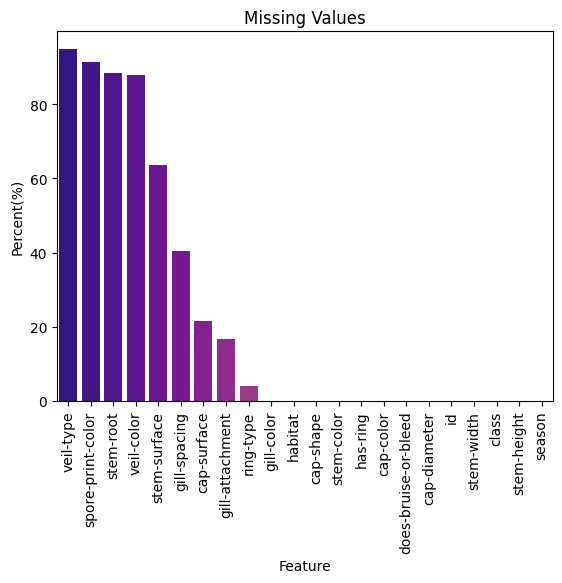

In [17]:
plot_missing_feature(df_train)

In [18]:
def columns_drop(df):
  column_drop=[]
  null_df=missing_feature(df)
  for col,val in null_df.items():
    if val >4:
      column_drop.append(col)
  return column_drop

In [19]:
column_drop_train = columns_drop(df_train)
print('-----------------------------------------')
print(column_drop_train)

-----------------------------------------
['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']


In [20]:
df_train.drop(column_drop_train,axis=1,inplace=True)
df_train.drop('id',axis=1,inplace=True)

In [21]:
df_train.isna().sum()

class                    0
cap-diameter             4
cap-shape               40
cap-color               12
does-bruise-or-bleed     8
gill-color              57
stem-height              0
stem-width               0
stem-color              38
has-ring                24
habitat                 45
season                   0
dtype: int64

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

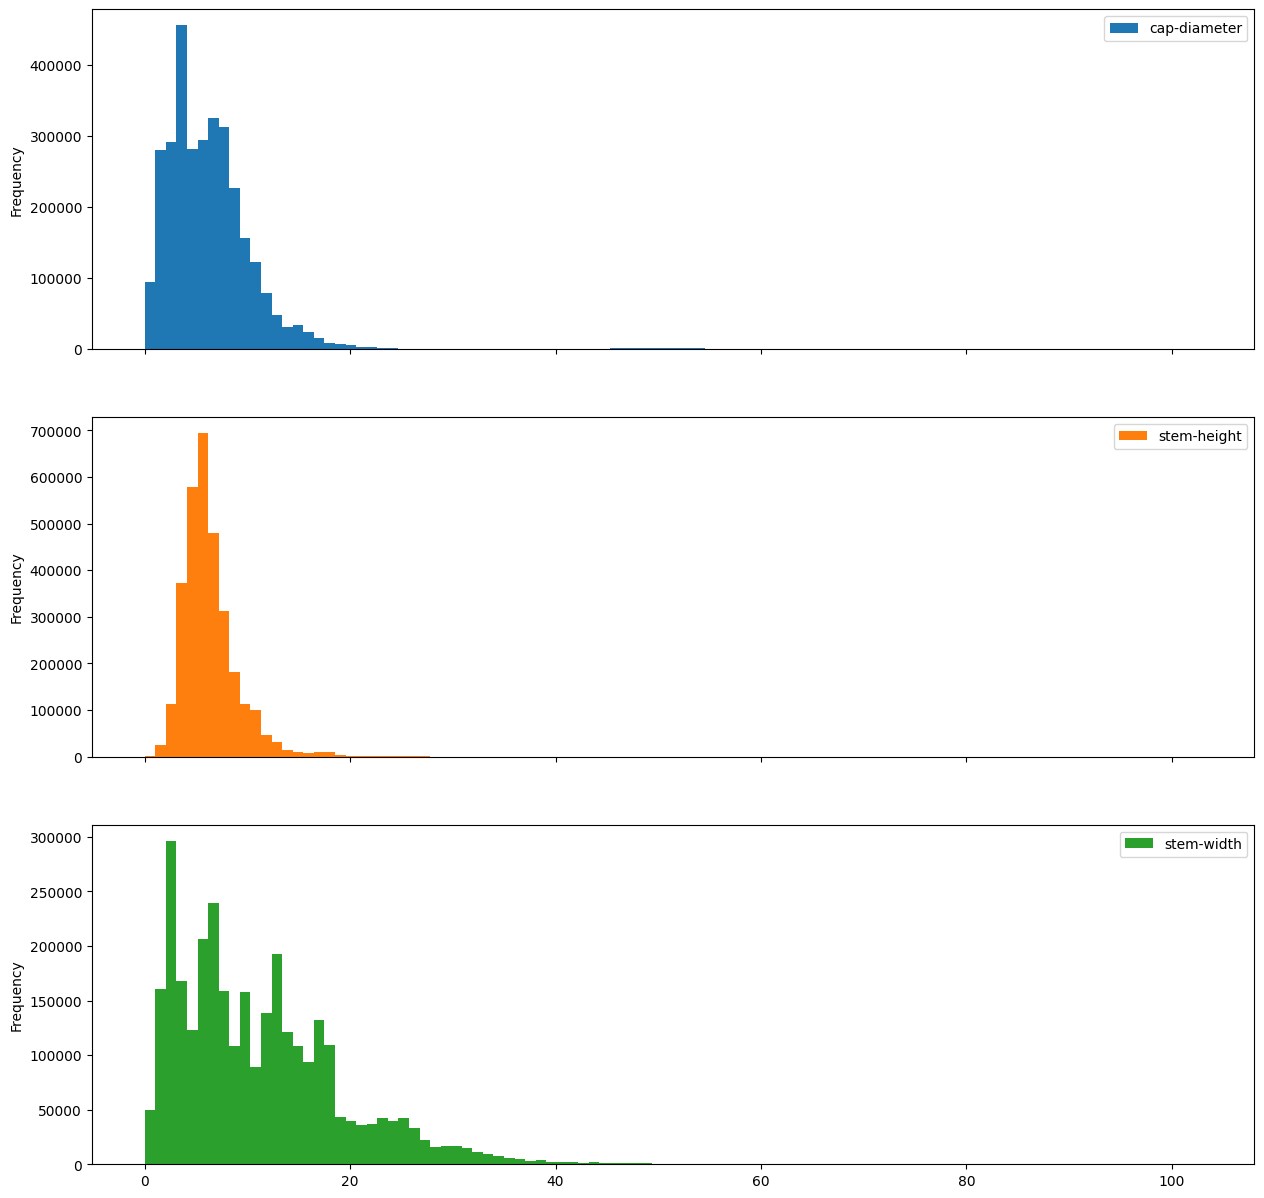

In [22]:
df_train.plot(kind='hist',subplots=True,sharex=True,figsize=(15,15),bins=100)

# **Splitting Data**

In [23]:
x=df_train.drop('class',axis=1)
y=df_train['class']
y=np.array([0 if i =='e' else 1 for i in y])
y.reshape(-1,1)

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=.7,stratify=y)

# **Pipeline**

In [25]:
num_data_train_columns = x.select_dtypes(include='number').columns
cat_data_train_columns = x.select_dtypes(include='category').columns
cat_data_train_columns

Index(['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color',
       'stem-color', 'has-ring', 'habitat', 'season'],
      dtype='object')

In [26]:
num_pipe=Pipeline (steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
cat_pipe=Pipeline (steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(sparse=False, handle_unknown='ignore'))
    # ('encoder',OrdinalEncoder())

])

In [27]:
df_preprocessing=ColumnTransformer(
     transformers=[
        ('num', num_pipe, num_data_train_columns),
        ('cat', cat_pipe, cat_data_train_columns)
    ]
)

In [28]:
final_pipe = Pipeline(steps=[
    ('preprocessor',df_preprocessing),
    ('PCA',PCA(n_components=.95)),
#     ('MCA',prince.MCA( n_components=2,  n_iter=3,       check_input=True, engine='auto',   random_state=42))

])

In [29]:
x_train=final_pipe.fit_transform(x_train)
x_test=final_pipe.transform(x_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **Modeling**

In [30]:
def Bayesian_Optimization (model,search_space):
  bayes = BayesSearchCV(model,
                        search_space,
                         n_iter= 10,
                        n_jobs=-1,
                        scoring='accuracy',
                        random_state=42)
  return bayes

In [31]:
xgb_space = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(2, 8),
    'learning_rate': Real(0.01, .4, 'log-uniform'),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'alpha':Real(.1,.5,'uniform'),
    'min_child_weight':Integer(5,10)
}
lgb_space={'num_leaves': Integer(24, 45),
          'feature_fraction': Real(0.1, 0.9),
          'bagging_fraction': Real(0.5, 1),
          'max_depth':Integer (5, 9),
          'lambda_l1':Real (0, 5),
          'lambda_l2':Real (0, 3),
          'min_split_gain':Real (0.001, 0.1),
          'min_child_weight': Integer(5, 60)
}
cat_space={
    'iterations': Integer(10, 100),
    'depth': Integer(1, 8),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'l2_leaf_reg': Real(1e-3, 10, 'log-uniform'),
    'border_count': Integer(32, 128)
}

In [32]:
clsss=len(y[y==0]) / len(y[y==1])
clsss

0.8276957375295826

In [33]:
xgb = XGBClassifier(random_state=42,scale_pos_weight =clsss)
# lgb = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42)
xgb_optimzied = Bayesian_Optimization(xgb,xgb_space)
# lgb_optimzied = Bayesian_Optimization(lgb,lgb_space)
cat_optimzied = Bayesian_Optimization(cat,cat_space)

In [34]:
xgb_optimzied.fit(x_train,y_train)
# lgb_optimzied.fit(x_train,y_train)
cat_optimzied.fit(x_train,y_train)

0:	learn: 0.6392199	total: 1.46s	remaining: 2m 15s
1:	learn: 0.6054989	total: 2.52s	remaining: 1m 55s
2:	learn: 0.5713125	total: 3.6s	remaining: 1m 49s
3:	learn: 0.5385241	total: 4.94s	remaining: 1m 51s
4:	learn: 0.5104640	total: 6.21s	remaining: 1m 50s
5:	learn: 0.4880630	total: 7.76s	remaining: 1m 53s
6:	learn: 0.4681432	total: 9.11s	remaining: 1m 53s
7:	learn: 0.4493242	total: 10.6s	remaining: 1m 53s
8:	learn: 0.4349688	total: 12.1s	remaining: 1m 54s
9:	learn: 0.4182046	total: 13.6s	remaining: 1m 53s
10:	learn: 0.4074930	total: 14.8s	remaining: 1m 51s
11:	learn: 0.3914498	total: 16.2s	remaining: 1m 50s
12:	learn: 0.3801035	total: 17.6s	remaining: 1m 49s
13:	learn: 0.3681178	total: 18.9s	remaining: 1m 48s
14:	learn: 0.3573413	total: 20.3s	remaining: 1m 46s
15:	learn: 0.3479236	total: 21.4s	remaining: 1m 44s
16:	learn: 0.3381635	total: 22.7s	remaining: 1m 42s
17:	learn: 0.3297625	total: 23.8s	remaining: 1m 40s
18:	learn: 0.3205880	total: 25.3s	remaining: 1m 39s
19:	learn: 0.3122996	to

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.6392442	total: 1.23s	remaining: 1m 53s
1:	learn: 0.6039948	total: 2.33s	remaining: 1m 47s
2:	learn: 0.5695637	total: 3.71s	remaining: 1m 52s
3:	learn: 0.5385222	total: 5.21s	remaining: 1m 57s
4:	learn: 0.5183025	total: 6.46s	remaining: 1m 54s
5:	learn: 0.4964370	total: 7.99s	remaining: 1m 57s
6:	learn: 0.4772462	total: 10.1s	remaining: 2m 5s
7:	learn: 0.4574646	total: 11.4s	remaining: 2m 2s
8:	learn: 0.4394948	total: 12.6s	remaining: 1m 59s
9:	learn: 0.4248201	total: 13.9s	remaining: 1m 56s
10:	learn: 0.4097450	total: 15.5s	remaining: 1m 56s
11:	learn: 0.3954824	total: 16.9s	remaining: 1m 55s
12:	learn: 0.3786972	total: 18.3s	remaining: 1m 53s
13:	learn: 0.3670376	total: 19.6s	remaining: 1m 52s
14:	learn: 0.3563228	total: 21.1s	remaining: 1m 51s
15:	learn: 0.3468258	total: 22.4s	remaining: 1m 49s
16:	learn: 0.3397124	total: 23.7s	remaining: 1m 47s
17:	learn: 0.3331106	total: 25s	remaining: 1m 45s
18:	learn: 0.3257036	total: 26.2s	remaining: 1m 43s
19:	learn: 0.3180597	total

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.6838158	total: 1.26s	remaining: 1m 19s
1:	learn: 0.6762009	total: 2.08s	remaining: 1m 4s
2:	learn: 0.6695020	total: 2.79s	remaining: 56.8s
3:	learn: 0.6634481	total: 3.54s	remaining: 53s
4:	learn: 0.6586460	total: 4.35s	remaining: 51.3s
5:	learn: 0.6535912	total: 5.22s	remaining: 50.4s
6:	learn: 0.6494521	total: 6.12s	remaining: 49.9s
7:	learn: 0.6452453	total: 6.91s	remaining: 48.4s
8:	learn: 0.6415431	total: 7.75s	remaining: 47.4s
9:	learn: 0.6370827	total: 8.69s	remaining: 46.9s
10:	learn: 0.6331980	total: 9.51s	remaining: 45.8s
11:	learn: 0.6295709	total: 10.3s	remaining: 44.6s
12:	learn: 0.6247975	total: 11.2s	remaining: 43.9s
13:	learn: 0.6218866	total: 11.9s	remaining: 42.5s
14:	learn: 0.6186879	total: 12.7s	remaining: 41.6s
15:	learn: 0.6157698	total: 13.5s	remaining: 40.6s
16:	learn: 0.6131192	total: 14.3s	remaining: 39.6s
17:	learn: 0.6088682	total: 15.2s	remaining: 38.9s
18:	learn: 0.6062641	total: 16.1s	remaining: 38.2s
19:	learn: 0.6037089	total: 16.8s	remainin

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 0.6258190	total: 1.27s	remaining: 1m 11s
1:	learn: 0.5753572	total: 2.39s	remaining: 1m 5s
2:	learn: 0.5440826	total: 3.44s	remaining: 1m 1s
3:	learn: 0.5154051	total: 4.41s	remaining: 58.4s
4:	learn: 0.4915222	total: 5.24s	remaining: 54.5s
5:	learn: 0.4709467	total: 6.23s	remaining: 53s
6:	learn: 0.4435426	total: 7.37s	remaining: 52.6s
7:	learn: 0.4280270	total: 8.44s	remaining: 51.7s
8:	learn: 0.4007655	total: 9.65s	remaining: 51.5s
9:	learn: 0.3856301	total: 10.8s	remaining: 50.7s
10:	learn: 0.3732060	total: 11.6s	remaining: 48.5s
11:	learn: 0.3607880	total: 12.5s	remaining: 46.9s
12:	learn: 0.3471938	total: 13.5s	remaining: 45.6s
13:	learn: 0.3371075	total: 14.3s	remaining: 44.1s
14:	learn: 0.3243560	total: 15.4s	remaining: 43.2s
15:	learn: 0.3157389	total: 16.5s	remaining: 42.3s
16:	learn: 0.3080267	total: 17.5s	remaining: 41.2s
17:	learn: 0.2986398	total: 18.6s	remaining: 40.3s
18:	learn: 0.2914860	total: 19.8s	remaining: 39.6s
19:	learn: 0.2864038	total: 20.7s	remainin

BayesSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7c8372a6fc70>,
              n_iter=10, n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'border_count': Integer(low=32, high=128, prior='uniform', transform='normalize'),
                             'depth': Integer(low=1, high=8, prior='uniform', transform='normalize'),
                             'iterations': Integer(low=10, high=100, prior='uniform', transform='normalize'),
                             'l2_leaf_reg': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize')})

In [35]:
xgb_optimzied.best_params_

OrderedDict([('alpha', 0.4249583953429453),
             ('colsample_bytree', 0.5859357806982803),
             ('learning_rate', 0.0908044841973702),
             ('max_depth', 7),
             ('min_child_weight', 8),
             ('n_estimators', 60),
             ('subsample', 0.8779002664179407)])

In [36]:
xgb=xgb_optimzied.best_estimator_
# lgb=lgb_optimzied.best_estimator_
cat=cat_optimzied.best_estimator_

In [37]:
y_pred_xgb=xgb.predict(x_test)
# y_pred_lgm=lgb.predict(x_test)
y_pred_cat=cat.predict(x_test)
print('XGB --> ',accuracy_score(y_test,y_pred_xgb))
# print('LGM --> ',accuracy_score(y_test,y_pred_lgm))
print('CAT --> ',accuracy_score(y_test,y_pred_cat))

XGB -->  0.9637337394287572
CAT -->  0.9653859974077195


In [38]:
voting_clf=VotingClassifier(estimators=[
        ('xgb', xgb),
        ('catboost', cat)
#         ,('lightbgm',lbm)
    ],
    voting='soft'
)
voting_clf.fit(x_train,y_train)
y_pred_voting=voting_clf.predict(x_test)
print('Voting Classifier Accuracy',accuracy_score(y_test,y_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

0:	learn: 0.6389020	total: 418ms	remaining: 38.9s
1:	learn: 0.6027647	total: 794ms	remaining: 36.5s
2:	learn: 0.5688023	total: 1.18s	remaining: 35.9s
3:	learn: 0.5375862	total: 1.62s	remaining: 36.4s
4:	learn: 0.5158314	total: 2.02s	remaining: 36s
5:	learn: 0.4975673	total: 2.41s	remaining: 35.3s
6:	learn: 0.4738089	total: 2.83s	remaining: 35.2s
7:	learn: 0.4561191	total: 3.25s	remaining: 35s
8:	learn: 0.4380461	total: 3.68s	remaining: 34.8s
9:	learn: 0.4217062	total: 4.08s	remaining: 34.3s
10:	learn: 0.4088733	total: 4.48s	remaining: 33.8s
11:	learn: 0.3985744	total: 4.83s	remaining: 33s
12:	learn: 0.3846944	total: 5.24s	remaining: 32.7s
13:	learn: 0.3726639	total: 5.67s	remaining: 32.4s
14:	learn: 0.3604307	total: 6.08s	remaining: 32s
15:	learn: 0.3493854	total: 6.44s	remaining: 31.4s
16:	learn: 0.3392930	total: 6.86s	remaining: 31.1s
17:	learn: 0.3310039	total: 7.23s	remaining: 30.5s
18:	learn: 0.3227342	total: 7.65s	remaining: 30.2s
19:	learn: 0.3151672	total: 8.04s	remaining: 29.7

In [39]:
import gc
gc.collect()

638

> ***Submession***

In [40]:
ts = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [41]:
df_test = copy.deepcopy(ts)
df_test.drop('id',axis=1,inplace=True)

In [42]:
columns_drop(ts)

['veil-type',
 'spore-print-color',
 'stem-root',
 'veil-color',
 'stem-surface',
 'gill-spacing',
 'cap-surface',
 'gill-attachment',
 'ring-type']

In [43]:
df_test=final_pipe.transform(df_test)

In [44]:
final_pred = voting_clf.predict(df_test)

In [45]:
final_pred_trans=['e' if i==0 else 'p' for i in final_pred]

In [46]:
submession= pd.DataFrame({'id':ts['id'].values,
                          'class':final_pred_trans
                         }
                        )


In [47]:
submession.to_csv('submession.csv',index=False)